# Brain Tumor Classification using Deep Learning

The following notebook will perform brain tumor classification using Deep Learning. Our objective is to use a [Kaggle](https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset) dataset consisting of 7022 brain scans of which includes brains with giloma tumor, meningioma tumor, pituitary tumor and healthy brains. 

<img src="https://www.stlukeshealth.org/content/dam/stlukeshealth/images/brain-cancer-banner.png" align="left" />

In [282]:
import numpy as np
import cv2, os, glob, random
import matplotlib.pyplot as plt
import elasticdeform

## Data exploration

Before jumping into writing models or makingg any statistical assesment, it is important that we study and understand the data we have. Let's plot some graphs and explore some numbers.

#### Place file paths in dictionary

In [283]:
training_images_paths = {}
testing_images_paths = {}

def add_img(d, imgType, imgPath):
    if imgType not in d:
        d[imgType] = [imgPath]
    else:
        d[imgType].append(imgPath)

for trainingImgPath in glob.glob("data/Training/*"):
    imgType = trainingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Training/{imgType}/*"):
        add_img(training_images_paths, imgType, img)
        
for testingImgPath in glob.glob("data/Testing/*"):
    imgType = testingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Testing/{imgType}/*"):
        add_img(testing_images_paths, imgType, img)

#### Plot training and test images quantity vs tumor type

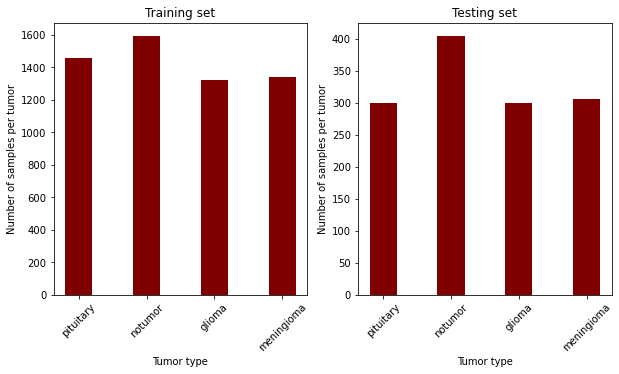

In [284]:
tumors = list(training_images_paths.keys())
tumorTrainingLength =  []
tumorTestingLength =  []

for tumorType in tumors:
    tumorTrainingLength.append(len(training_images_paths[tumorType]))
    tumorTestingLength.append(len(testing_images_paths[tumorType]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(tumors, tumorTrainingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Training set")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(tumors, tumorTestingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Testing set")
plt.xticks(rotation=45)

plt.show()

The dataset are well balanced in both training and testing sets.

#### Data observation
Let's observe some brain scans of different types of brain tumors.

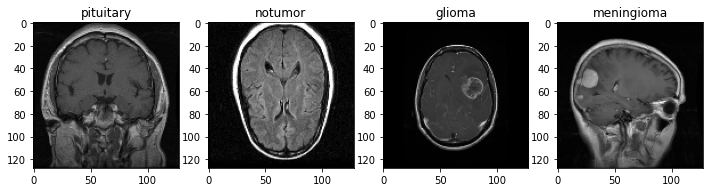

In [285]:
plt.figure(figsize = (12, 5))
for index, tumor in enumerate(tumors):
    imgPath = training_images_paths[tumor][random.randint(1,len(training_images_paths[tumor]))]
    img = cv2.imread(imgPath, 0)
    img = cv2.resize(img, (128,128))
    img = np.array(img)/128
    plt.subplot(1,4,(index+1))
    plt.title(tumor)
    plt.imshow(img, cmap='gray')

## Data transformation

Now that we are more familiar with the data, let's start thinking of transformations we can apply. We will start off by performing basic operations such as data loaders, label encoder and decoder. From there, we will apply transformations on the MRI scans and finally normalize the data.

In [286]:
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data.dataloader import DataLoader

In [287]:
class powerGammaEnhance(object):
    def __call__(self, img):
        randGammaValue = random.uniform(0.4, 0.8)
        gammaImg = np.array(128*(img.numpy() / 128) ** randGammaValue)
        t = torch.from_numpy(gammaImg)
        return t
    
class elasticTransform(object):
    def __call__(self, img):
        elasticDeformedImg = elasticdeform.deform_random_grid(img.numpy(), sigma=1.1, points=3)
        t = torch.from_numpy(elasticDeformedImg)
        return t

In [288]:
dataTransformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    powerGammaEnhance(),
#     elasticTransform(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_set = ImageFolder("./data/Training", transform=dataTransformer)
train_loader = DataLoader(training_set, 10, shuffle=True)
labelDict = dict((v,k) for k,v in training_set.class_to_idx.items())

In [302]:
from itertools import chain

train_paths = list(chain.from_iterable(training_images_paths.values()))
len(train_loader)*10

5720

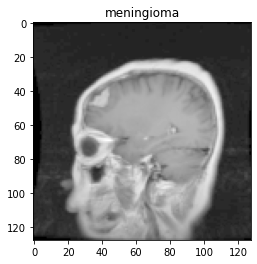

In [289]:
for img, label in train_loader:
    plt.title(labelDict[label[0].item()])
    plt.imshow(img[0].squeeze()[0,:,:], cmap='gray')
    break

## Model

Our data generator is now ready to feed batches of data into a model. Let's design a model and pass it our training data.

In [290]:
import torch
import torch.nn as nn
from torchvision import models

In [291]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(32*64*64, 4)
        
    def forward(self,img):
        output=self.conv1(img)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*64*64)
        output=self.fc(output)
        return output


In [279]:
from torch.optim import Adam
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()


In [304]:
from torch.optim import Adam
best_accuracy=0.0
model = ConvNet()
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

for epoch in range(5):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/len(train_loader)*10
    train_loss=train_loss/len(train_loader)*10
    
    
    # Evaluation on testing dataset
#     model.eval()
    
#     test_accuracy=0.0
#     for i, (images,labels) in enumerate(test_loader):
#         if torch.cuda.is_available():
#             images=Variable(images.cuda())
#             labels=Variable(labels.cuda())
            
#         outputs=model(images)
#         _,prediction=torch.max(outputs.data,1)
#         test_accuracy+=int(torch.sum(prediction==labels.data))
    
#     test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy))
    

Epoch: 0 Train Loss: tensor(320.4251) Train Accuracy: 72.6923076923077
Epoch: 1 Train Loss: tensor(27.0575) Train Accuracy: 91.87062937062936
Epoch: 2 Train Loss: tensor(15.2292) Train Accuracy: 94.94755244755245
Epoch: 3 Train Loss: tensor(12.4039) Train Accuracy: 95.506993006993
Epoch: 4 Train Loss: tensor(9.6507) Train Accuracy: 97.09790209790211
